# Generative Models: Deep Convolutional Generative Adversarial Network (DCGAN)

## Setting up working environment
You will need to install pytorch and import some utilities by running the following cell:

In [ ]:
!pip install -q torch torchvision altair seaborn
!git clone -q https://github.com/afspies/icl_dl_cw2_utils
from icl_dl_cw2_utils.utils.plotting import plot_tsne
from pathlib import Path
import tqdm

Here I have some default pathing options which vary depending on the environment you are using. You can of course change these as you please.

In [ ]:
WORKING_ENV = 'COLAB' # Can be LABS, COLAB or PAPERSPACE
USERNAME = 'afs219' # If working on Lab Machines - Your college username
assert WORKING_ENV in ['LABS', 'COLAB', 'PAPERSPACE']

if WORKING_ENV == 'COLAB':
    from google.colab import drive
    %load_ext google.colab.data_table
    content_path = '/content/drive/MyDrive/Deep_Learning/'
    data_path = './data/'
    drive.mount('/content/drive/') # Outputs will be saved in your google drive

elif WORKING_ENV == 'LABS':
    content_path = '~/Documents/dl_cw_2' # You may want to change this
    # Your python env and training data should be on bitbucket
    data_path = f'/vol/bitbucket/{USERNAME}/dl_cw_data/'

else: # Using Paperspace
    content_path = '/notebooks'
    data_path = './data/'

content_path = Path(content_path)

Mounted at /content/drive/


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists(content_path/'CW_VAE/'):
    os.makedirs(content_path/'CW_VAE/')

if not os.path.exists(data_path):
    os.makedirs(data_path)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

Using cuda


## Part 1

In this task, I train a [DCGAN](https://arxiv.org/abs/1511.06434) on the CIFAR-10 dataset. I experiment with different architectures and tricks for stability in training (such as using different activation functions, batch normalization, different values for the hyper-parameters, etc.). In the end, I provide: 

- my best trained model, 
- some generations for the fixed latent vectors $\mathbf{z}\sim \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)$, 
- plots with the losses for the discriminator $D$ and the generator $G$ as the training progresses and an explaination on whether the produced plots are theoretically sensible and why this is (or not) the case. 
- a discussion on whether if I noticed any mode collapse, where this behaviour may be attributed to, and explanations of what you did in order to cope with mode collapse. 

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import torch.nn.functional as F
import matplotlib.pyplot as plt

mean = torch.Tensor([0.4914, 0.4822, 0.4465])
std = torch.Tensor([0.247, 0.243, 0.261])
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x, channels=None, w=None ,h=None, resize = False):
    
    x = unnormalize(x)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists(content_path/'CW_GAN'):
    os.makedirs(content_path/'CW_GAN')

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

Using cuda


### Part 1a: Implement DCGAN

I use the architecture desribed in the DCGAN paper (https://arxiv.org/abs/1511.06434).

Some general reccomendations:
- add several convolutional layers (3-4).
- accelerate training with batch normalization after every convolutional layer.
- use the appropriate activation functions. 
- Generator module: the upsampling can be done with various methods, such as nearest neighbor upsampling (`torch.nn.Upsample`) or transposed convolutions(`torch.nn.ConvTranspose2d`). 
- Discriminator module: Experiment with batch normalization (`torch.nn.BatchNorm2d`) and leaky relu (`torch.nn.LeakyReLu`) units after each convolutional layer.

#### Data loading

In [ ]:
# batch_size =  128
batch_size =  64
# batch_size =  16
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=mean, std=std),                        
])
# note - data_path was initialized at the top of the notebook
cifar10_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=batch_size)
loader_test = DataLoader(cifar10_test, batch_size=batch_size)
# print(torch.max(loader_train.dataset[0][0]))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


We'll visualize a subset of the test set: 

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


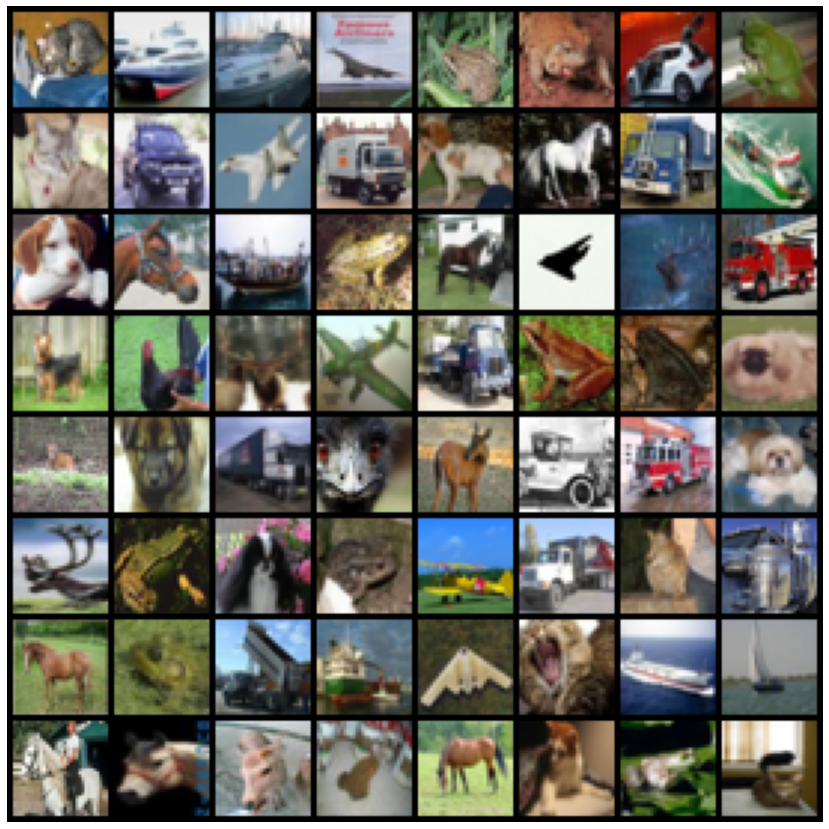

In [ ]:
samples, _ = next(iter(loader_test))

samples = samples.cpu()
samples = make_grid(denorm(samples), nrow=8, padding=2, normalize=False,
                        range=None, scale_each=False, pad_value=0)
plt.figure(figsize = (15,15))
plt.axis('off')
show(samples)

#### Model Definition
Define hyperparameters and the model

In [ ]:
# Choose the number of epochs, the learning rate
# and the size of the Generator's input noise vetor.

num_epochs_gan = 20
# learning_rate = 0.0002
learning_rate_G = 4e-4 # 1e-4 # 6e-4
learning_rate_D = 1e-4 # 4e-4 # 2e-4
latent_vector_size = 100 # latent_vector: 16

# Other hyperparams


##### Version 1

In [ ]:
class Generator(nn.Module):
    def __init__(self, img_size=28):
        super(Generator, self).__init__()

        ngf = 64 # size of feature maps of generator
        self.conv_blocks = nn.Sequential(   
                            nn.ConvTranspose2d(latent_vector_size, ngf*8, kernel_size=4, stride=1, padding=0, bias=False),  
                            nn.BatchNorm2d(ngf*8),
                            nn.ReLU(),
                            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False), 
                            nn.BatchNorm2d(ngf*4),
                            nn.ReLU(),
                            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),  
                            nn.BatchNorm2d(ngf*2),
                            nn.ReLU(),
                            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
                            nn.BatchNorm2d(ngf),
                            nn.ReLU(),
                            nn.ConvTranspose2d(ngf, 3, 1, 1, 0, bias=False),
                            ) 
        
        # Input Dimension: (latent_vector_size)
        # Input Dimension: (64*8) x 4 x 4
        # Input Dimension: (64*4) x 8 x 8
        # Input Dimension: (64*2) x 16 x 16
        # Input Dimension: (64) x 32 x 32
        # Output Dimension: (3) x 64 x 64 

    def forward(self, z):
        for layer in self.conv_blocks:
            z = layer(z)
        out = z
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        ndf = 64 # size of feature maps of discriminator
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(3, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(),
            nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(),
            nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(),
            nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(),
            nn.Conv2d(ndf*8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid(),
            )

        # Input Dimension: (nc) x 64 x 64
        # Input Dimension: (ndf) x 32 x 32
        # Input Dimension: (ndf*2) x 16 x 16
        # Input Dimension: (ndf*4) x 8 x 8
        # Input Dimension: (ndf*8) x 4 x 4
        # Output Dimension: (1) x 1 x 1 
        
    def forward(self, x):
        for layer in self.conv_blocks:
            # print("x.shape", x.shape)
            x = layer(x)
        out = x
        return out

#                       ** CODE USED FOR TESTING CLASS **
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)

def loss_function(out, label):
    loss = nn.BCELoss(reduction = 'mean')
    return loss(out, label)

beta1 = 0.5
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate, betas=(beta1, 0.999))

fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

train_losses_G = []
train_losses_D = []

print("Starting Training Loop...")
print("-"*25)

real_label = 1
fake_label = 0

for epoch in range(num_epochs):
    # <- You may wish to add logging info here
    with tqdm.tqdm(loader_train, unit="batch") as tepoch: 
        for i, data in enumerate(tepoch):
            train_loss_D = 0
            train_loss_G = 0
            
            real_data = data[0].to(device)
            batch_size = real_data.size(0)

            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))

            # train with real
            # Make accumalated gradients of the discriminator zero.
            model_D.zero_grad()
            # Create labels for the real data. (label=1)
            label = torch.full((batch_size, ), real_label, device=device)
            label = label.to(torch.float32)
            ### print()
            ### print("real_data.shape", real_data.shape)
            ### print("model_D(real_data).shape", model_D(real_data).shape)
            output = model_D.forward(real_data).view(-1)
            errD_real = loss_function(output, label)
            # Calculate gradients for backpropagation.
            errD_real.backward()
            D_x = output.mean().item()

            # train with fake
            # Sample random data from a unit normal distribution.
            noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
            # Generate fake data (images).
            fake_data = model_G(noise)
            # Create labels for fake data. (label=0)
            label.fill_(fake_label)
            # Calculate the output of the discriminator of the fake data.
            # As no gradients w.r.t. the generator parameters are to be
            # calculated, detach() is used. Hence, only gradients w.r.t. the
            # discriminator parameters will be calculated.
            # This is done because the loss functions for the discriminator
            # and the generator are slightly different.
            ### print("fake_data.shape", fake_data.shape)
            output = model_D(fake_data.detach()).view(-1)
            ### print("output.shape", output.shape)
            errD_fake = loss_function(output, label)
            # Calculate gradients for backpropagation.
            errD_fake.backward()
            D_G_z1 = output.mean().item()

            # Net discriminator loss.
            errD = errD_real + errD_fake
            # Update discriminator parameters.
            optimizerD.step()

            # Make accumalted gradients of the generator zero.
            model_G.zero_grad()
            # We want the fake data to be classified as real. Hence
            # real_label are used. (label=1)
            label.fill_(real_label)
            # No detach() is used here as we want to calculate the gradients w.r.t.
            # the generator this time.
            output = model_D(fake_data).view(-1)
            errG = loss_function(output, label)
            # Gradients for backpropagation are calculated.
            # Gradients w.r.t. both the generator and the discriminator
            # parameters are calculated, however, the generator's optimizer
            # will only update the parameters of the generator. The discriminator
            # gradients will be set to zero in the next iteration by netD.zero_grad()
            errG.backward()


            # (2) Update G network: maximize log(D(G(z)))
            D_G_z2 = output.mean().item()
            # Update generator parameters.
            optimizerG.step()

            # Save the losses for plotting.
            train_loss_G += errG.item()
            train_loss_D += errD.item()
            break

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-45ba2b671ab6>", line 111, in <module>
    model_G = Generator().to(device)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 899, in to
    return self._apply(convert)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 570, in _apply
    module._apply(fn)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 570, in _apply
    module._apply(fn)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 593, in _apply
    param_applied = fn(param)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 897, in convert
    return t.to(device, dtype if t.is_floating_point() or t.is_complex() else None, non_blocking)
KeyboardInterrupt

During

KeyboardInterrupt: ignored

##### Version 2

In [ ]:
class Generator(nn.Module):
    def __init__(self, img_size=28):
        super(Generator, self).__init__()

        ngf = 64 # size of feature maps of generator
        # standardise the input
        self.conv_blocks = nn.Sequential(   
                            nn.ConvTranspose2d(latent_vector_size, ngf*8, kernel_size=4, stride=1, padding=0, bias=False),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False), 
                            nn.BatchNorm2d(ngf*4),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),  
                            nn.BatchNorm2d(ngf*2),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
                            nn.BatchNorm2d(ngf),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.ConvTranspose2d(ngf, 3, 1, 1, 0, bias=False),
                            ) 
        
        # Input Dimension: (latent_vector_size)
        # Input Dimension: (64*8) x 4 x 4
        # Input Dimension: (64*4) x 8 x 8
        # Input Dimension: (64*2) x 16 x 16
        # Input Dimension: (64) x 32 x 32
        # Output Dimension: (3) x 64 x 64

    def forward(self, z):
        for layer in self.conv_blocks:
            z = layer(z)
        out = z
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        """Remove upsample"""
        ndf = 64 # size of feature maps of discriminator
        self.conv_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(3, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid(),
            )

        # Input Dimension: (nc) x 64 x 64
        # Input Dimension: (ndf) x 32 x 32
        # Input Dimension: (ndf*2) x 16 x 16
        # Input Dimension: (ndf*4) x 8 x 8
        # Input Dimension: (ndf*8) x 4 x 4
        # Output Dimension: (1) x 1 x 1 
        
    def forward(self, x):
        for layer in self.conv_blocks:
            # print("x.shape", x.shape)
            x = layer(x)
        out = x
        return out

#                       ** CODE USED FOR TESTING CLASS **
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)

def loss_function(out, label):
    loss = nn.BCELoss(reduction = 'mean')
    return loss(out, label)

beta1 = 0.5
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate, betas=(beta1, 0.999))

fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

train_losses_G = []
train_losses_D = []

print("Starting Training Loop...")
print("-"*25)

real_label = 1
fake_label = 0

for epoch in range(num_epochs):
    # <- You may wish to add logging info here
    with tqdm.tqdm(loader_train, unit="batch") as tepoch: 
        for i, data in enumerate(tepoch):
            train_loss_D = 0
            train_loss_G = 0
            
            real_data = data[0].to(device)
            batch_size = real_data.size(0)

            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))

            # train with real
            # Make accumalated gradients of the discriminator zero.
            model_D.zero_grad()
            # Create labels for the real data. (label=1)
            label = torch.full((batch_size, ), real_label, device=device)
            label = label.to(torch.float32)
            ### print()
            ### print("real_data.shape", real_data.shape)
            ### print("model_D(real_data).shape", model_D(real_data).shape)
            output = model_D.forward(real_data).view(-1)
            errD_real = loss_function(output, label)
            # Calculate gradients for backpropagation.
            errD_real.backward()
            D_x = output.mean().item()

            # train with fake
            # Sample random data from a unit normal distribution.
            noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
            # Generate fake data (images).
            fake_data = model_G(noise)
            # Create labels for fake data. (label=0)
            label.fill_(fake_label)
            # Calculate the output of the discriminator of the fake data.
            # As no gradients w.r.t. the generator parameters are to be
            # calculated, detach() is used. Hence, only gradients w.r.t. the
            # discriminator parameters will be calculated.
            # This is done because the loss functions for the discriminator
            # and the generator are slightly different.
            ### print("fake_data.shape", fake_data.shape)
            output = model_D(fake_data.detach()).view(-1)
            ### print("output.shape", output.shape)
            errD_fake = loss_function(output, label)
            # Calculate gradients for backpropagation.
            errD_fake.backward()
            D_G_z1 = output.mean().item()

            # Net discriminator loss.
            errD = errD_real + errD_fake
            # Update discriminator parameters.
            optimizerD.step()

            # Make accumalted gradients of the generator zero.
            model_G.zero_grad()
            # We want the fake data to be classified as real. Hence
            # real_label are used. (label=1)
            label.fill_(real_label)
            # No detach() is used here as we want to calculate the gradients w.r.t.
            # the generator this time.
            output = model_D(fake_data).view(-1)
            errG = loss_function(output, label)
            # Gradients for backpropagation are calculated.
            # Gradients w.r.t. both the generator and the discriminator
            # parameters are calculated, however, the generator's optimizer
            # will only update the parameters of the generator. The discriminator
            # gradients will be set to zero in the next iteration by netD.zero_grad()
            errG.backward()


            # (2) Update G network: maximize log(D(G(z)))
            D_G_z2 = output.mean().item()
            # Update generator parameters.
            optimizerG.step()

            # Save the losses for plotting.
            train_loss_G += errG.item()
            train_loss_D += errD.item()
            break

##### Version 3

In [ ]:
class Generator(nn.Module):
    def __init__(self, img_size=28):
        super(Generator, self).__init__()
        ngf = 128 # 64 # size of feature maps of generator
        # standardise the input
        self.conv_blocks = nn.Sequential(   
                            nn.ConvTranspose2d(latent_vector_size, ngf*8, kernel_size=4, stride=1, padding=0, bias=False),
                            # nn.BatchNorm2d(ngf*8),
                            nn.ReLU(),
                            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False), 
                            nn.BatchNorm2d(ngf*4),
                            nn.ReLU(),
                            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),  
                            nn.BatchNorm2d(ngf*2),
                            nn.ReLU(),
                            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
                            nn.BatchNorm2d(ngf),
                            nn.ReLU(),
                            nn.ConvTranspose2d(ngf, 3, 1, 1, 0, bias=False),
                            nn.Tanh()) 
        
        # Input Dimension: (latent_vector_size)
        # Input Dimension: (64*8) x 4 x 4
        # Input Dimension: (64*4) x 8 x 8
        # Input Dimension: (64*2) x 16 x 16
        # Input Dimension: (64) x 32 x 32
        # Output Dimension: (3) x 64 x 64

        self.alpha = nn.Parameter(torch.Tensor([2.8]), requires_grad=True)
        self.register_parameter(name='alpha', param=self.alpha)

    def forward(self, z):
        for layer in self.conv_blocks:
            z = layer(z)
            # print(z.shape)
        z = z.mul(self.alpha) # Use learnable parameter
        # z = z.mul(2.8)
        out = z
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        """Remove upsample"""
        ndf = 64 # size of feature maps of discriminator
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(3, ndf, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid(),
            )

        # Input Dimension: (nc) x 32 x 32
        # Input Dimension: (ndf) x 32 x 32
        # Input Dimension: (ndf*2) x 16 x 16
        # Input Dimension: (ndf*4) x 8 x 8
        # Input Dimension: (ndf*8) x 4 x 4
        # Output Dimension: (1) x 1 x 1
        
    def forward(self, x):
        for layer in self.conv_blocks:
            # print("x.shape", x.shape)
            x = layer(x)
        out = x
        return out

#                       ** CODE USED FOR TESTING CLASS **
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)

def loss_function(out, label):
    loss = nn.BCELoss(reduction = 'mean')
    return loss(out, label)

beta1 = 0.5
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate_D, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate_G, betas=(beta1, 0.999))

fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

train_losses_G = []
train_losses_D = []

print("Starting Training Loop...")
print("-"*25)

real_label = 1
fake_label = 0

for epoch in range(num_epochs):
    # <- You may wish to add logging info here
    with tqdm.tqdm(loader_train, unit="batch") as tepoch: 
        for i, data in enumerate(tepoch):
            train_loss_D = 0
            train_loss_G = 0
            
            real_data = data[0].to(device)
            batch_size = real_data.size(0)

            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))

            # train with real
            # Make accumalated gradients of the discriminator zero.
            optimizerD.zero_grad()
            # Create labels for the real data. (label=1)
            label = torch.full((batch_size, ), real_label, device=device)
            label = label.to(torch.float32)
            ### print()
            ### print("real_data.shape", real_data.shape)
            ### print("model_D(real_data).shape", model_D(real_data).shape)
            output = model_D.forward(real_data).view(-1)
            errD_real = loss_function(output, label)
            # Calculate gradients for backpropagation.
            errD_real.backward()
            D_x = output.mean().item()

            # train with fake
            # Sample random data from a unit normal distribution.
            noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
            # Generate fake data (images).
            fake_data = model_G(noise)
            # Create labels for fake data. (label=0)
            label.fill_(fake_label)
            # Calculate the output of the discriminator of the fake data.
            # As no gradients w.r.t. the generator parameters are to be
            # calculated, detach() is used. Hence, only gradients w.r.t. the
            # discriminator parameters will be calculated.
            # This is done because the loss functions for the discriminator
            # and the generator are slightly different.
            ### print("fake_data.shape", fake_data.shape)
            output = model_D(fake_data.detach()).view(-1)
            ### print("output.shape", output.shape)
            errD_fake = loss_function(output, label)
            # Calculate gradients for backpropagation.
            errD_fake.backward()
            D_G_z1 = output.mean().item()

            # Net discriminator loss.
            errD = errD_real + errD_fake
            # Update discriminator parameters.
            optimizerD.step()

            # Make accumalted gradients of the generator zero.
            optimizerG.zero_grad()
            # We want the fake data to be classified as real. Hence
            # real_label are used. (label=1)
            label.fill_(real_label)
            # No detach() is used here as we want to calculate the gradients w.r.t.
            # the generator this time.
            output = model_D(fake_data).view(-1)
            errG = loss_function(output, label)
            # Gradients for backpropagation are calculated.
            errG.backward()

            # (2) Update G network: maximize log(D(G(z)))
            D_G_z2 = output.mean().item()
            # Update generator parameters.
            optimizerG.step()

            # Save the losses for plotting.
            train_loss_G += errG.item()
            train_loss_D += errD.item()
            break

Starting Training Loop...
-------------------------


  0%|          | 0/782 [00:00<?, ?batch/s]


##### Version 4

In [ ]:
class Generator(nn.Module):
    def __init__(self, img_size=28):
        super(Generator, self).__init__()
        ngf = 128 # 64 # size of feature maps of generator
        # standardise the input
        self.conv_blocks = nn.Sequential(   
                            nn.ConvTranspose2d(latent_vector_size, ngf*8, kernel_size=4, stride=1, padding=0, bias=False),
                            nn.BatchNorm2d(ngf*8),
                            nn.ReLU(True),
                            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False), 
                            nn.BatchNorm2d(ngf*4),
                            nn.ReLU(True),
                            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),  
                            nn.BatchNorm2d(ngf*2),
                            nn.ReLU(True),
                            nn.ConvTranspose2d(ngf*2, ngf*1, 4, 2, 1, bias=False),
                            nn.BatchNorm2d(ngf*1),
                            nn.ReLU(True),
                            nn.ConvTranspose2d(ngf*1, 3, 1, 1, 0, bias=False),
                            nn.Tanh()) 
        
        # Input Dimension: (latent_vector_size)
        # Input Dimension: (64*8) x 4 x 4
        # Input Dimension: (64*4) x 8 x 8
        # Input Dimension: (64*2) x 16 x 16
        # Input Dimension: (64) x 32 x 32
        # Output Dimension: (3) x 64 x 64

        self.alpha = nn.Parameter(torch.Tensor([2.8]), requires_grad=True)
        self.register_parameter(name='alpha', param=self.alpha)

    def forward(self, z):
        for layer in self.conv_blocks:
            z = layer(z)
            # print(z.shape)
        z = z.mul(self.alpha) # Use learnable parameter
        # z = z.mul(2.8)
        out = z
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        """Remove upsample"""
        ndf = 64 # size of feature maps of discriminator
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(3, ndf, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid(),
            )

        # Input Dimension: (nc) x 32 x 32
        # Input Dimension: (ndf) x 32 x 32
        # Input Dimension: (ndf*2) x 16 x 16
        # Input Dimension: (ndf*4) x 8 x 8
        # Input Dimension: (ndf*8) x 4 x 4
        # Output Dimension: (1) x 1 x 1
        
    def forward(self, x):
        for layer in self.conv_blocks:
            # print("x.shape", x.shape)
            x = layer(x)
        out = x 
        return out

#                       ** CODE USED FOR TESTING CLASS **
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)

def loss_function(out, label):
    loss = nn.BCELoss(reduction = 'mean')
    return loss(out, label)

beta1 = 0.5
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate_D, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate_G, betas=(beta1, 0.999))

fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

train_losses_G = []
train_losses_D = []

print("Starting Training Loop...")
print("-"*25)

real_label = 0.9 # 1
fake_label = 0

for epoch in range(num_epochs):
    # <- You may wish to add logging info here
    with tqdm.tqdm(loader_train, unit="batch") as tepoch: 
        for i, data in enumerate(tepoch):
            train_loss_D = 0
            train_loss_G = 0
            
            real_data = data[0].to(device)
            batch_size = real_data.size(0)

            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))

            # train with real
            # Make accumalated gradients of the discriminator zero.
            optimizerD.zero_grad()
            # Create labels for the real data. (label=1)
            label = torch.full((batch_size, ), real_label, device=device)
            label = label.to(torch.float32)
            ### print()
            ### print("real_data.shape", real_data.shape)
            ### print("model_D(real_data).shape", model_D(real_data).shape)
            output = model_D.forward(real_data).view(-1)
            errD_real = loss_function(output, label)
            # Calculate gradients for backpropagation.
            errD_real.backward()
            D_x = output.mean().item()

            # train with fake
            # Sample random data from a unit normal distribution.
            noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
            # Generate fake data (images).
            fake_data = model_G(noise)
            # Create labels for fake data. (label=0)
            label.fill_(fake_label)
            # Calculate the output of the discriminator of the fake data.
            # As no gradients w.r.t. the generator parameters are to be
            # calculated, detach() is used. Hence, only gradients w.r.t. the
            # discriminator parameters will be calculated.
            # This is done because the loss functions for the discriminator
            # and the generator are slightly different.
            ### print("fake_data.shape", fake_data.shape)
            output = model_D(fake_data.detach()).view(-1)
            ### print("output.shape", output.shape)
            errD_fake = loss_function(output, label)
            # Calculate gradients for backpropagation.
            errD_fake.backward()
            D_G_z1 = output.mean().item()

            # Net discriminator loss.
            errD = errD_real + errD_fake
            # Update discriminator parameters.
            optimizerD.step()

            # Make accumalted gradients of the generator zero.
            optimizerG.zero_grad()
            # We want the fake data to be classified as real. Hence
            # real_label are used. (label=1)
            label.fill_(real_label)
            # No detach() is used here as we want to calculate the gradients w.r.t.
            # the generator this time.
            output = model_D(fake_data).view(-1)
            errG = loss_function(output, label)
            # Gradients for backpropagation are calculated.
            errG.backward()

            # (2) Update G network: maximize log(D(G(z)))
            D_G_z2 = output.mean().item()
            # Update generator parameters.
            optimizerG.step()

            # Save the losses for plotting.
            train_loss_G += errG.item()
            train_loss_D += errD.item()
            break

Starting Training Loop...
-------------------------


NameError: ignored

#### Initialize Model and print number of parameters

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

### Part 1b: Training the Model

#### Defining a Loss

In [1]:
def loss_function(out, label):
    loss = nn.BCELoss()
    return loss(out, label)

#### Choose and initialize optimizers

In [ ]:
# setup optimizer
beta1 = 0.5
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate_D, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate_G, betas=(beta1, 0.999))
# optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate, betas=(beta1, 0.999))
# optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate, betas=(beta1, 0.999))

#### Define fixed input vectors to monitor training and mode collapse.

In [ ]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)


#### Training Loop

I've defined some variables to keep track of things during training:
* errD: Loss of Discriminator after being trained on real and fake instances
* errG: Loss of Generator
* D_x: Output of Discriminator for real images
* D_G_z1: Output of Discriminator for fake images (When Generator is not being trained)
* D_G_z2: Output of Discriminator for fake images (When Generator is being trained)

In [ ]:
import pickle 

train_losses_G = []
train_losses_D = []
epochs = []

print("Starting Training Loop...")
print("-"*25)

num_epochs_gan = 20
real_label = 0.9 # 1
fake_label = 0

for epoch in range(num_epochs_gan):
    train_loss_D = 0
    train_loss_G = 0
    with tqdm.tqdm(loader_train, unit="batch") as tepoch: 
        for i, data in enumerate(tepoch):
            
            real_data = data[0].to(device)
            batch_size = real_data.size(0)
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ############################

            # train with real
            optimizerD.zero_grad()
            label = torch.full((batch_size, ), real_label, device=device)
            label = label.to(torch.float32)
            
            output = model_D.forward(real_data).view(-1)
            errD_real = loss_function(output, label)
            ### Calculate gradients for backpropagation.
            errD_real.backward()
            D_x = output.mean().item()

            # train with fake
            fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
            ### Generate fake data (images).
            fake_data = model_G(fixed_noise)
            ### Create labels for fake data. (label=0)
            label.fill_(fake_label)

            output = model_D.forward(fake_data.detach()).view(-1)
            # print(fake_data.shape)
            # print(output.shape)
            errD_fake = loss_function(output, label)
            ### Calculate gradients of discriminator for backpropagation.
            errD_fake.backward()
            D_G_z1 = output.mean().item()

            ### Net discriminator loss.
            errD = errD_real + errD_fake
            ### Update discriminator parameters.
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ############################

            ### Make accumalted gradients of the generator zero.
            optimizerG.zero_grad()
            label.fill_(real_label)
            
            output = model_D(fake_data).view(-1)
            errG = loss_function(output, label)
            ### Calculate gradients of generator for backpropagation.
            errG.backward()
            D_G_z2 = output.mean().item()
            
            ### Update generator parameters.
            optimizerG.step()

            ### Save the losses for plotting.
            train_loss_G += errG.item()
            train_loss_D += errD.item()

            # Logging 
            if i % 50 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(D_G_z=f"{D_G_z1:.3f}/{D_G_z2:.3f}", D_x=D_x,
                                  Loss_D=errD.item(), Loss_G=errG.item())
    
    if epoch == 0:
        save_image(denorm(real_data.cpu()).float(), content_path/'CW_GAN/real_samples.png')
    with torch.no_grad():
        fake = model_G(fixed_noise)
        save_image(denorm(fake_data.cpu()).float(), str(content_path/'CW_GAN/fake_samples_epoch_%03d.png') % epoch)
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))
    epochs.append(epoch)
    # save  models 
    torch.jit.save(torch.jit.trace(model_G, (fixed_noise)), str(content_path/'CW_GAN/GAN_G_model_epoch_%03d.pth') % epoch)
    torch.jit.save(torch.jit.trace(model_D, (fake)), str(content_path/'CW_GAN/GAN_D_model_epoch_%03d.pth') % epoch)
    
    # save losses
    with open(f'{content_path}/CW_GAN/losses_GANS{epoch}.pkl', 'wb') as f:
            losses = {"Train losses Discriminator": train_losses_D, "Train losses Generator": train_losses_G}
            pickle.dump(losses, f)

# save  models 
torch.jit.save(torch.jit.trace(model_G, (fixed_noise)), content_path/f'CW_GAN/GAN_G_model.pth')
torch.jit.save(torch.jit.trace(model_D, (fake)), content_path/f'CW_GAN/GAN_D_model.pth')

Epoch 19: 100%|██████████| 3125/3125 [02:19<00:00, 22.36batch/s, D_G_z=0.026/0.122, D_x=0.453, Loss_D=0.951, Loss_G=3, Output_scale=3.98]


### Part 1c: Results
The table below shows examples of what are considered good samples. Level 3 being the best to level 1 being the worst.

<table><tr>
<td> 
  <p align="center" style="padding: 10px">
    <img alt="Forwarding" src="https://drive.google.com/uc?id=1wQ2f10-A1Vs7k0LMfBPPyYTsPlkBF9QE" width="%30">
    <br>
    <em style="color: grey">Level 1</em>
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="Routing" src="https://drive.google.com/uc?id=1wlDhX4hROET4s8Ndxn8nhj_0RLM2rnuG" width="%30">
    <br>
    <em style="color: grey">Level 2</em>
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="Routing" src="https://drive.google.com/uc?id=1w9VrgfJLCRaTPhwoFVYdYhtCeaQmFHGb" width="%30">
    <br>
    <em style="color: grey">Level 3</em>
  </p> 
</td>
</tr></table>

#### Generator samples

In [ ]:
# Load the models trained
number = num_epochs_gan - 1
print(number)
model_D = torch.jit.load(content_path/"CW_GAN/GAN_D_model.pth")
model_G = torch.jit.load(content_path/"CW_GAN/GAN_G_model.pth")

19


/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


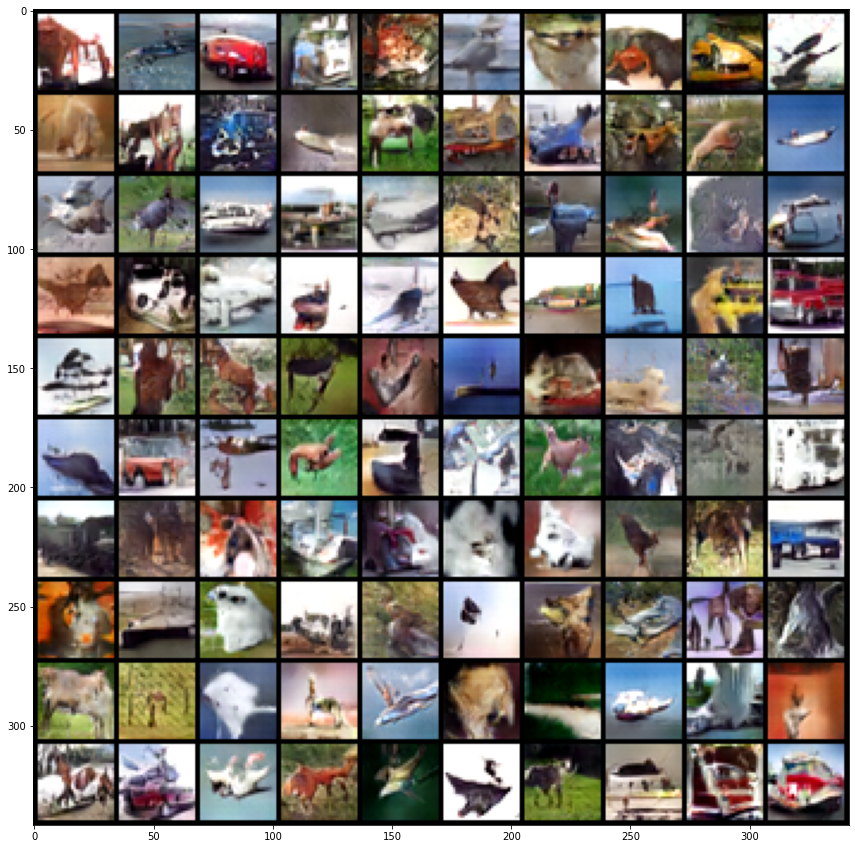

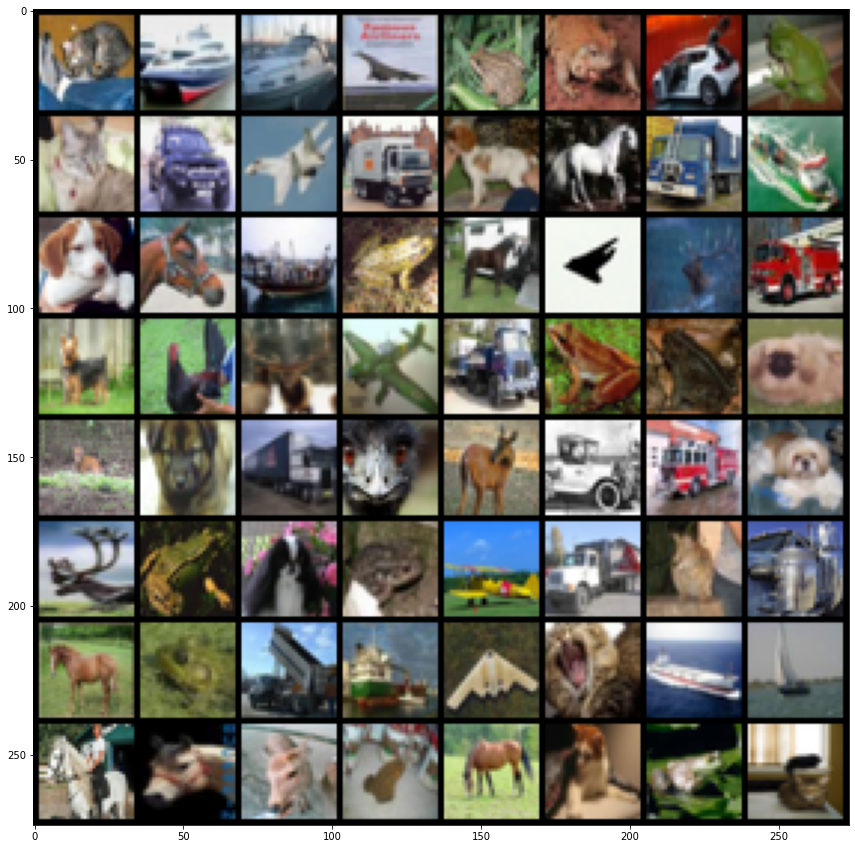

In [ ]:
input_noise = torch.randn(100, latent_vector_size, 1, 1, device=device)
with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:100], nrow=10, padding=2, normalize=False, 
                        range=None, scale_each=False, pad_value=0)
    plt.figure(figsize=(15,15))
    save_image(generated, content_path/'CW_GAN/Teaching_final.png')
    show(generated) # note these are now class conditional images columns rep classes 1-10

it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:64, :, :, :]
# visualize the original images of the last batch of the test set for comparison
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(15,15))
show(img)

### Part 1d: Engineering Choices

I discuss the process you took to arrive at your final architecture. This includes: 
* Which empirically useful methods did I utilize
* What didn't work, what worked and what mattered most
* Are there any tricks I came across in the literature etc. which I suspect would be helpful here

Text(0.5, 1.0, 'distribution of pixels')

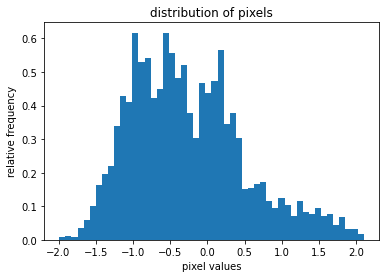

In [ ]:
# Show histogram of pixel values
img_pil = loader_train.dataset[0][0]
plt.hist(img_pil.numpy().ravel().ravel(), bins=50, density=True);
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

The paper used as recommendation for these implementations was https://arxiv.org/pdf/1511.06434.pdf.

The only difference with the image above and the model used is that the output size of the image was 32 by 32 instead of 64 by 64.

**Upsample:** At the beginning instead of adapting the initial architecture so that the discriminator received images of 32 by 32 instead of 64 by 64 an Upsample layer was introduced. What this did was it multiplied the height and the width with a scale factor of 2 so it became a 64 by 64 image. However, this produced worse results than adapting the kernel sizes and padding of each layer given a 32 by 32 image as input in the first layer.

**Tanh:** What can be seen from the histogram above is that the data after normalisation lies between -2.6 and 2.8. When using a basic Tanh activation function for the generator the images generated were a bit dark. This is because the Tanh activation function was clipping the outputs between 1 and -1, not allowing any bright colours to be represented. Hence, I have implemented a learnable parameter called $alpha$ that multiplies the Tanh function outputs to account for this range. A Tanh was used instead of not using an activation function as it allowed the model to learn more quickly to saturate and cover the colour space of the training distribution.

**Batch size:** 64 as a higher batch size hurts the performance because during the initial training the generator might get too many examples overfitting it too quickly. Smaller batch sizes were tested but the network overfit too much and produced random images. An example of such can be seen below as Figure 1.

**Different learning rates for generator and discriminator:** The original learning rate for both the generator and discriminator was 0.0002. However, I gave the generator a learning rate of 0.0001 and the discriminator was given a learning rate of 0.0004 so that the generator has to make smaller steps to fool the discriminator and does not choose fast, unprecise and unrealistic solutions.

**Momentum term beta 1:** I used a value of 0.5, as any higher resulted in training oscillation and instability

**Batch Normalisation:** Batch normalisation was used for all the layers except the first and last one for both the generator and discriminator. This stabilised learning by normalising input to each unit to have zero mean and unit variance. This helps in solving training issues that develop because of inadequate initialization, as well as the gradient flow in deeper models. This was crucial for deep generators to start learning since it prevented the generator from collapsing all samples into a single point, which is a common failure mechanism in GANs. When batch norm was applied directly to all layers, however, sample oscillation and model instability followed. Hence, why I did not apply to either the first or last layer.

**Leaky ReLU:** Using evidence from these two papers, we found out that it was not only beneficial to use Leaky RELU in the discriminator. I tried using Leaky RELU as well in the generator but it performed worse, which makes sense as we do not want to generate negative pixel values.
https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html
https://arxiv.org/pdf/1505.00853.pdf

**Number of epochs:** Different values were tested: 10, 20 and 30, but 10 underfitted and 30 overfitted (Figure 2) so in the end I chose 20.

**Label smoothing:** The label for real images was originally set 1. I decreased it to 0.9 as this causes the discriminator to stop being overconfident about its classification. 

**Loss function:** I used a binary cross entropy loss function. I tried using other more complex loss function such as the Wassertein loss function (Figure 3) from this paper (https://arxiv.org/pdf/1701.07875.pdf ) but as this paper points out (https://arxiv.org/pdf/1811.09567.pdf ) and from what can be seen in Figure 3, the loss function used has a very small effect on performance.
The loss function we are using:
 * Discriminator loss: $E[\log D(x)] + E[\log (1 - D(G(z)))]$
 * Generator loss: $E[\log (D(G(z)))]$

In WGAN we use:
 * Discriminator loss: $E[D(x)] + E[D(G(z))]$
 * Generator loss: $E[D(G(z))]$
 * $W_D ← clip(W_D, -0.01, 0.01)$

**Number of features:** Number of features of generator is 128 and the number of features of discriminator is 64. These numbers were originally 64 (giving an output that can be seen in Figure 4), but as the process of the generator is more complex (creating an image than classifying an image) more features were needed.

**Latent size:** The latent size from this paper (https://arxiv.org/pdf/1511.06434.pdf) was 100 and from what I saw from other literature most of the DCGAN models used a latent size of 100 when using the CIFAR-10 dataset as input. Therefore, this number was not changed.

In conclusion, the changes that had the largest effect in performance were the changes done to the network architecture, the rest had an effect but not as significant. Moreover, choosing the right number of epochs was crucial to generate an image that did not underfit or overfit.

Figure 1:

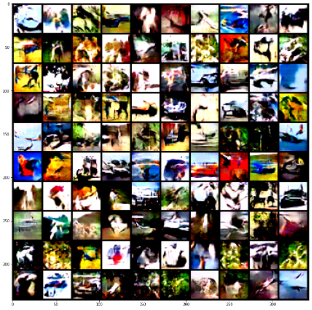

Figure 2:

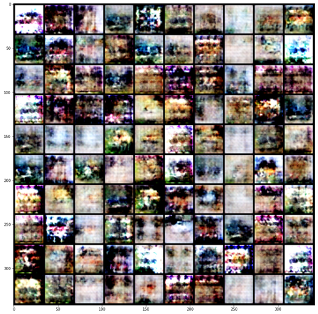

Figure 3:

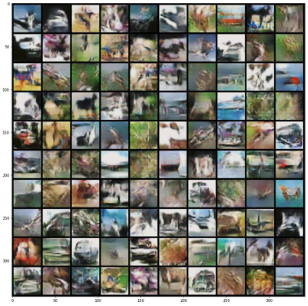

Figure 4:

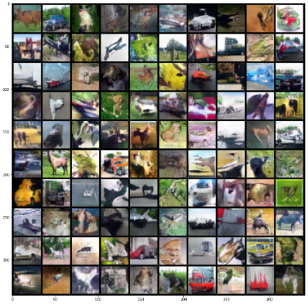

## Part 2: Understanding GAN Training


### Loss Curves

I plot the losses curves for the discriminator $D$ and the generator $G$ as the training progresses and explain whether the produced curves are theoretically sensible and why this is (or not) the case (x-axis: epochs, y-axis: loss).

In [ ]:
# Load losses
import pickle

number = num_epochs_gan - 1
with open(f'{content_path}/CW_GAN/losses_GANS{number}.pkl', 'rb') as f:
    losses = pickle.load(f)


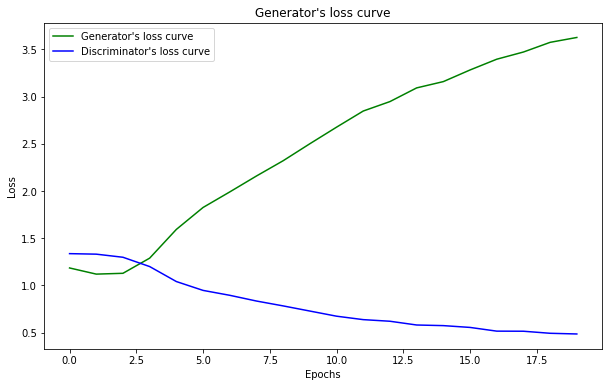

In [ ]:
plt.figure(figsize=(16,8))
plt.title(rf'Loss curves for GAN')
colors = ["green", "blue"]
i = 0
for loss_name, loss in losses.items():
    plt.plot(loss, label=str(loss_name), color=colors[i])
    plt.xlabel('Epoch number')
    plt.ylabel("Loss")
    i += 1
plt.legend()
plt.savefig(f'{content_path}/loss_curves_dis_gen.png', bbox_inches='tight', dpi=150)
plt.show()

### Discussion

**Do the loss curves look sensible? What would I expect to see and why?**

What can be seen here is that the generator and discriminator are playing a minimax game, when one decreases the other one increases and vice versa. We can be satisfied with the results of the loss functions as both the discriminator and the generator converge to some constants. This means that the GAN model has found some optimum, where it can't improve more, which also should mean that it has learned well enough. Even though the loss function diagram shows us that the network as trained nicely, the only true way to validate this, is to evaluate it by translating and plotting some images of the test set.

## Part 3: Understanding Mode Collapse
 
I describe the what causes the phenomenon of Mode Collapse and how it may manifest in the samples from a GAN.

In [ ]:
# Any additional code

### Discussion


**What is mode collapse?**

The generator is always trying to find the one output that seems most plausible to the discriminator. So, if the generator produces an especially plausible output, the generator may learn to produce only that output. If this is the case, the discriminator's best strategy is to learn to always reject that output. But if in the next generation the discriminator gets stuck in a local minimum and doesn't find the best strategy, then the generator will continue to produce that output and the discriminator never manages to learn its way out of the trap. This is called model collapse.

**Based on the images created by my generator using the “fixed noise” vector during training, did I notice any mode collapse?**

You can detect model collapse when you see the loss functions converge but the discriminator cannot distinguish the genuine data (this can be seen of the same or variation of the image are repeatedly generated). We can see from the generated image, that even though some images share some features this cannot be considered model collapse.

**How did I try to eliminate/reduce it?**
The solution used to solve/avoid mode collapse was to lower the learning rate (before I had a learning rate of 0.0002 for the generator which was reduced to 0.0001).  This solved the problem, but other methods that could be have been used that solve the problem were using feature matching or minibatch discrimination.


*   **Feature matching:** what feature matching does is change the goal of the generator from beating the discriminator to matching the features of real images. The new objective function would be the following:
 $||E_{x ∼ p_{data}}f(x) - E_{x ∼ p_{z}(z)}f(G(x))||_2^2$ where $p_{data}$ is the distribution of the real images and $p_{z}(z)$ is the distribution of the generated images.
*   **Minibatch discrimination:** avoids mode collapsing by feeding real and generated images to the discriminator in different batches. We then compute the similarity of an image with the rest of the images from that same batch. This similarity metric is added to a fully connected layers in the discriminator. This helps the discriminator detect when similar images are being created and penalise this type of behaviour.
